In [2]:
# fit PCA on the hormone data with speed as exogenous variable
import numpy as np
import pandas as pd
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import Lasso
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import spearmanr
# load data
# horm_beh = np.load('preprocessed_hormones_behavior.npy', allow_pickle=True).item()
horm_beh = np.load('preprocessed_hormones_behavior_last_animal.npy', allow_pickle=True).item()
X1m = horm_beh['X1m'].T
X1a = horm_beh['X1a'].T
X2m = horm_beh['X2m'].T
X2a = horm_beh['X2a'].T
X3 = horm_beh['X3'].T
y1m = horm_beh['y1m']
y1a = horm_beh['y1a']
y2m = horm_beh['y2m']
y2a = horm_beh['y2a']
y3 = horm_beh['y3']
common_comps = horm_beh['common_comps']

In [3]:
# things to think about:
# robust zscore rowas X across animals before PCA
# use spearman correlation instead of pearson
# compute partial Spearman correlations, and maybe look at PCA of that? Only maybe
# look at similarity across animals of Spearman correlations and partial correlatons
# use spearman cross correlation to check PC vs behavior
# look at loadings of first PC
# look at transition from wake to sleep in PC space (maybe high-D plot?)

In [4]:
# robust z-score
def z_score_rows(mat):
    abs_dev = np.median(np.abs(mat - np.median(mat, axis=0)), axis=0)
    return (mat - np.median(mat, axis=0)) / abs_dev

In [5]:
# robust z-score for each individual animal first
def robust_zscore(data, axis=0, log_transform=False, exclude_outliers=False):
    if log_transform:
        data = np.log(data)
    median = np.nanmedian(data, axis=axis)
    mad = np.nanmedian(np.abs(data - median), axis=axis)
    zscore = (data - median) / mad
    if exclude_outliers:
        zscore[np.abs(zscore) > 3] = np.nan
    return zscore

X1 = robust_zscore(np.concatenate([X1m, X1a], axis=0), log_transform=False)
X2 = robust_zscore(np.concatenate([X2m, X2a], axis=0), log_transform=False)
X3 = robust_zscore(X3, log_transform=False)

y1 = np.concatenate([y1m, y1a], axis=0)
y2 = np.concatenate([y2m, y2a], axis=0)
y3 = y3

X = np.concatenate([X1, X2, X3], axis=0)
y = np.concatenate([y1, y2, y3], axis=0)
n_samples, n_features = X.shape
print(X.shape, y.shape)

(174, 155) (174,)


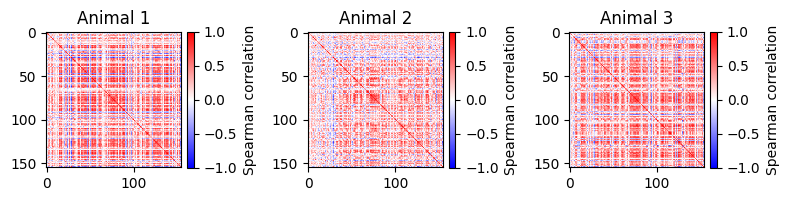

In [6]:
# first things first: plot the three spearman correlation matrices
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
def plot_spearman_corr(X, title):
    corr, _ = spearmanr(X)
    plt.imshow(corr, vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar(label='Spearman correlation', fraction=0.046, pad=0.04)
    plt.title(title)
    # plt.xticks(np.arange(len(common_comps)), common_comps, rotation=90)
    # plt.yticks(np.arange(len(common_comps)), common_comps)
    plt.tight_layout()
plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plot_spearman_corr(X1, 'Animal 1')
plt.subplot(1, 3, 2)
plot_spearman_corr(X2, 'Animal 2')
plt.subplot(1, 3, 3)
plot_spearman_corr(X3, 'Animal 3')
# plt.savefig('spearman_corr_matrices.pdf', dpi=300)
plt.show()

In [7]:
# compute cosine similarity across the three spearman correlation matrices
from sklearn.metrics.pairwise import cosine_similarity
rs = [spearmanr(Xi)[0] for Xi in [X1, X2, X3]]
sim_matrix = cosine_similarity([r.flatten() for r in rs])

In [8]:
sim_matrix

array([[1.        , 0.55960825, 0.59544305],
       [0.55960825, 1.        , 0.54919637],
       [0.59544305, 0.54919637, 1.        ]])

In [70]:
# compute partial correlation between compounds in X1m taking into account y1m
from sklearn.linear_model import LinearRegression

# partial autocorrelation -- compute the autocorrelation of residuals?

def comp_resids(X, y):
    n_compounds = X.shape[1]
    resids = np.zeros_like(X)
    for i in range(n_compounds):
        model = LinearRegression().fit(y.reshape(-1, 1), X[:, i])
        resids[:, i] = X[:, i] - model.predict(y.reshape(-1, 1))
    return resids

def partial_corr(X, y):
    n_compounds = X.shape[1]
    resids = comp_resids(X, y)
    p_corr = np.zeros((n_compounds, n_compounds))
    for i in range(n_compounds):
        for j in range(n_compounds):
            if i == j:
                p_corr[i, j] = 1.0
            else:
                # compute correlation between residuals
                # p_corr[i, j] = np.corrcoef(resids[:, i], resids[:, j])[0, 1]
                p_corr[i, j] = spearmanr(resids[:, i], resids[:, j])[0]
    return p_corr

def partial_autocorr(X, y):
    resids = comp_resids(X, y)
    pacf_values = np.zeros((X.shape[1], 5))
    for i in range(X.shape[1]):
        pacf_values[i] = pacf(resids[:, i], nlags=5)
    return pacf_values
# compute partial correlation for each compound in each dataset
pacs = {}
for name, data, y in zip(['X1', 'X2', 'X3'], [X1, X2, X3], [y1, y2, y3]):
    pacs[name] = partial_corr(data, y)

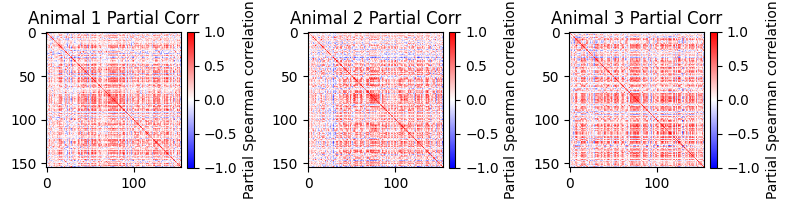

In [71]:
# plot the three partial correlation matrices
import matplotlib.pyplot as plt
def plot_partial_corr(p_corr, title):
    plt.imshow(p_corr, vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar(label='Partial Spearman correlation', fraction=0.046, pad=0.04)
    plt.title(title)
    # plt.xticks(np.arange(len(common_comps)), common_comps, rotation=90)
    # plt.yticks(np.arange(len(common_comps)), common_comps)
    plt.tight_layout()
plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plot_partial_corr(pacs['X1'], 'Animal 1 Partial Corr')
plt.subplot(1, 3, 2)
plot_partial_corr(pacs['X2'], 'Animal 2 Partial Corr')
plt.subplot(1, 3, 3)
plot_partial_corr(pacs['X3'], 'Animal 3 Partial Corr')
# plt.savefig('partial_spearman_corr_matrices.pdf', dpi=300)
plt.show()

In [9]:
# compute the spearman r for X1, X2, and X3 with the columns normalized
def rob_zscore(data, axis=0, log_transform=False, exclude_outliers=False):
    if log_transform:
        data = np.log(data)
    median = np.nanmedian(data, axis=axis)
    mad = np.nanmedian(np.abs(data - median), axis=axis)
    zscore = (data - median) / mad
    if exclude_outliers:
        zscore[np.abs(zscore) > 3] = np.nan
    return zscore

X1n = rob_zscore(X1.T, log_transform=False).T
X2n = rob_zscore(X2.T, log_transform=False).T
X3n = rob_zscore(X3.T, log_transform=False).T

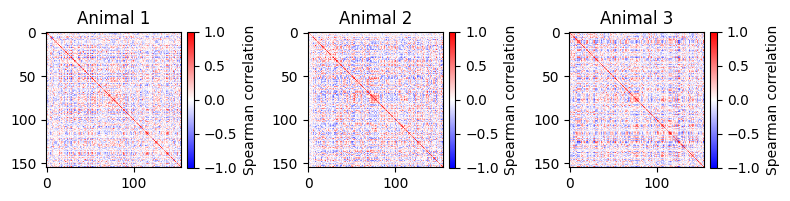

In [10]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plot_spearman_corr(X1n, 'Animal 1')
plt.subplot(1, 3, 2)
plot_spearman_corr(X2n, 'Animal 2')
plt.subplot(1, 3, 3)
plot_spearman_corr(X3n, 'Animal 3')
# plt.savefig('spearman_corr_matrices_Columns_norm.pdf', dpi=300)
plt.show()

In [11]:
# compute cosine similarity of those three
cosine_similarity(spearmanr(X1n)[0], spearmanr(X2n)[0]), cosine_similarity(spearmanr(X1n)[0], spearmanr(X3n)[0]), cosine_similarity(spearmanr(X2n)[0], spearmanr(X3n)[0])

(array([[ 0.25882732, -0.02278154,  0.2966678 , ...,  0.3047775 ,
          0.09497335,  0.55486218],
        [ 0.27924928,  0.21020331,  0.15258274, ...,  0.11988876,
         -0.14113669,  0.52413674],
        [ 0.15265828,  0.06709969,  0.22151202, ...,  0.1103631 ,
         -0.08844875,  0.19299083],
        ...,
        [ 0.22005503, -0.13660983,  0.34176897, ...,  0.37889007,
          0.21723942,  0.56317497],
        [-0.2299209 , -0.15102717, -0.09347825, ..., -0.05762208,
          0.36068325, -0.31182391],
        [ 0.31369177, -0.01437419,  0.30091952, ...,  0.32096707,
          0.07670259,  0.68250083]]),
 array([[ 0.35983948,  0.52186308,  0.13781226, ..., -0.25737798,
         -0.07468911,  0.51729849],
        [ 0.38291688,  0.63195654,  0.13270669, ..., -0.26109928,
         -0.17098437,  0.54078549],
        [ 0.26707584,  0.23300421,  0.40727431, ..., -0.02704162,
         -0.32896314,  0.16561954],
        ...,
        [ 0.23387745,  0.49647258, -0.00685158, ..., -

Text(0.5, 1.0, 'Spearman Correlation: X2n vs X2')

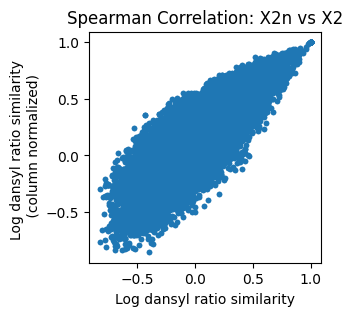

In [12]:
plt.figure(figsize=(3, 3))
plt.scatter(spearmanr(X2n)[0].flatten(), spearmanr(X2)[0].flatten(),marker='.',rasterized=True)
plt.xlabel('Log dansyl ratio similarity')
plt.ylabel('Log dansyl ratio similarity \n (column normalized)')
plt.title('Spearman Correlation: X2n vs X2')
# plt.savefig('spearman_corr_scatter_X2n_vs_X2.pdf', dpi=300)

In [14]:
spearmanr(X2n.flatten(), X2.flatten())

SignificanceResult(statistic=np.float64(0.878395134426901), pvalue=np.float64(0.0))

In [40]:
# compute cosine similarity between the spearman correlation matrices
def cosine_similarity(mat1, mat2):
    from sklearn.metrics.pairwise import cosine_similarity
    return cosine_similarity(mat1.flatten().reshape(1, -1), mat2.flatten().reshape(1, -1))[0, 0]
sim_matrix = np.zeros((3, 3))
names = ['X1', 'X2', 'X3']
for i in range(3):
    for j in range(3):
        sim_matrix[i, j] = cosine_similarity(pacs[names[i]], pacs[names[j]])
sim_matrix

array([[1.        , 0.56134904, 0.60020155],
       [0.56134904, 1.        , 0.52241359],
       [0.60020155, 0.52241359, 1.        ]])

In [15]:
# cluster spearman correlation matrix into 6 clusters using hierarchical clustering
Z = linkage(spearmanr(X)[0], method='ward')
clusters = fcluster(Z, 5, criterion='maxclust')

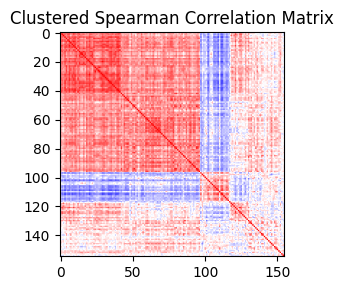

In [16]:
# plot matrix reordered according to cluster identity
def plot_clustered_corr(corr, clusters):
    # order by clusters
    order = np.argsort(clusters)
    clustered_corr = corr[order][:, order]
    plt.figure(figsize=(3, 3))
    plt.imshow(clustered_corr, vmin=-1, vmax=1, cmap='bwr')
    plt.title('Clustered Spearman Correlation Matrix')
    plt.tight_layout()
plot_clustered_corr(spearmanr(X)[0], clusters)
# plt.savefig('clustered_spearman_corr_matrix.pdf', dpi=300)

In [17]:
# compute within block vs outside block correlations
within_block_corrs = []
outside_block_corrs = []
for i in range(1, 6):
    block_indices = np.where(clusters == i)[0]
    outside_indices = np.where(clusters != i)[0]
    block_corrs = spearmanr(X[:, block_indices])[0]
    outside_corrs = spearmanr(X[:, outside_indices])[0]
    # get upper triangle values excluding diagonal
    within_block_corrs.extend(block_corrs[np.triu_indices_from(block_corrs, k=1)])
    outside_block_corrs.extend(outside_corrs[np.triu_indices_from(outside_corrs, k=1)])

In [20]:
np.median(within_block_corrs)/np.median(outside_block_corrs)

np.float64(2.091909086265665)

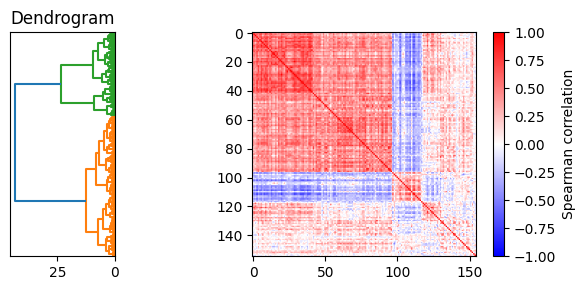

In [13]:
# same as above but also add dendrogram to the side!!
from scipy.cluster.hierarchy import dendrogram
def plot_clustered_corr_with_dendrogram(corr, clusters):
    # order by clusters
    order = np.argsort(clusters)
    clustered_corr = corr[order][:, order]
    fig, ax = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={'width_ratios': [1, 4]})
    dendrogram(linkage(corr, method='ward'), ax=ax[0], orientation='left', no_labels=True)
    ax[0].set_title('Dendrogram')
    im = ax[1].imshow(clustered_corr, vmin=-1, vmax=1, cmap='bwr')
    # ax[1].set_title('Clustered Spearman Correlation Matrix')
    fig.colorbar(im, ax=ax[1], label='Spearman correlation', fraction=0.046, pad=0.04)
    plt.tight_layout()
    # plt.show()
plot_clustered_corr_with_dendrogram(spearmanr(X)[0], clusters)
plt.savefig('clustered_spearman_corr_matrix_with_dendrogram.pdf', dpi=300)

/home/nardinm@hhmi.org/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


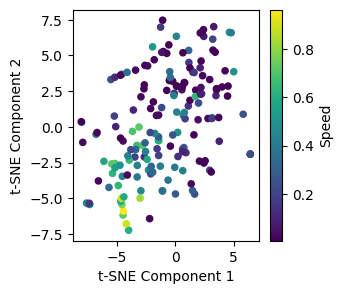

In [72]:
# t-SNE of hormone data?
# load tsne
from sklearn.manifold import TSNE
# fit tsne on hormone data
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
X_tsne = tsne.fit_transform(X)
# plot tsne
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
y = np.concatenate([y1, y2, y3], axis=0)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=20)
plt.colorbar(label='Speed')
# plt.title('t-SNE of Hormone Data Colored by Speed')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig('tsne_hormone_data_speed.pdf', dpi=300)
plt.show()


In [9]:
# run PCA on X
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)  # retain 90% of variance
X_reduced = pca.fit_transform(X)
n_reduced_features = X_reduced.shape[1]
print(f'Reduced from {n_features} to {n_reduced_features} features.')

Reduced from 155 to 28 features.


In [10]:
# import SpearmanPCA.py
import SpearmanPCA

In [11]:
rpca = SpearmanPCA.SpearmanRobustPCA(
    n_components=20,
    gaussianize=True,   # rank → normal scores
    center='median',
    scale='mad',
    handle_missing='pairwise',
    whiten=False
)
scores = rpca.fit_transform(X)

In [12]:
rpca.explained_variance_ratio_

array([0.32310912, 0.08408692, 0.06433354, 0.05834412, 0.03946678,
       0.03782383, 0.02919263, 0.02566853, 0.02364835, 0.01863915,
       0.01620465, 0.01430855, 0.01364507, 0.01294053, 0.01184514,
       0.01125197, 0.01085427, 0.01005717, 0.0089849 , 0.00855881])

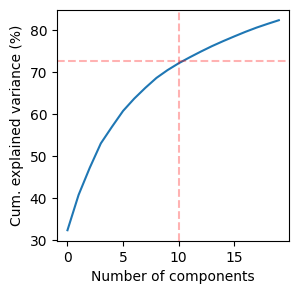

In [13]:
# plot explained variance
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.plot(np.cumsum(rpca.explained_variance_ratio_)*100)
plt.xlabel('Number of components')
plt.ylabel('Cum. explained variance (%)')
plt.axvline(x=10, color='r', alpha=0.3, linestyle='--')
plt.axhline(y=72.5, color='r', alpha=0.3, linestyle='--')

# plt.savefig('rpca_explained_variance.pdf', dpi=300)

In [14]:
def log_pos_neg(x):
    return np.sign(x) * np.log1p(np.abs(x))

In [15]:
X_reduced = scores

In [16]:
from scipy.stats import spearmanr
# spearman R cross correlation
def spearman_ccf(x, y, max_lag):
    lags = np.arange(-max_lag+1, max_lag)
    ccf = [spearmanr(x[max_lag+lag:-max_lag+lag], 
                     y[max_lag: -max_lag])[0] for lag in lags]
    return lags, ccf

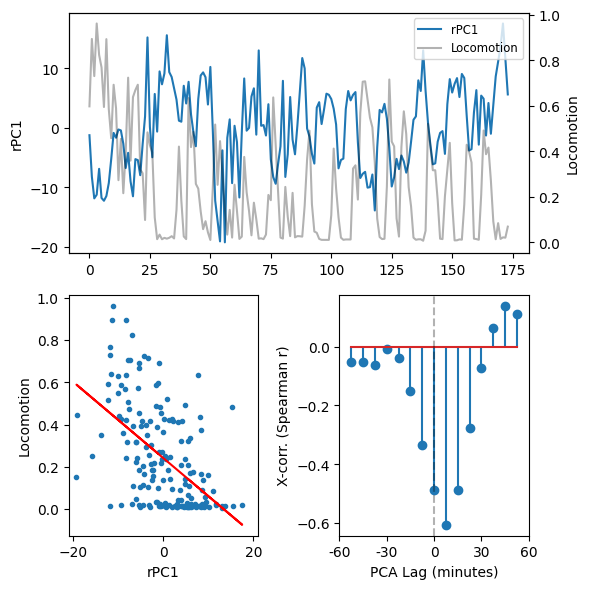

In [17]:
# scatter plot y vs first two principal components
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(X_reduced[:, 0])
plt.ylabel('rPC1')
plt.twinx()
plt.plot(0,0,label='rPC1')
plt.plot(y, color='k',alpha=0.3, label='Locomotion')
plt.ylabel('Locomotion')
plt.legend(loc='upper right', fontsize='small')
plt.subplot(2, 2, 3)
plt.scatter(X_reduced[:, 0],y,rasterized=True,marker='.')
m, b = np.polyfit(X_reduced[:, 0], y, 1)
plt.plot(X_reduced[:, 0], m*X_reduced[:, 0] + b, color='red')
plt.xlim(-21,21)
plt.xlabel('rPC1')
plt.ylabel('Locomotion')

plt.subplot(2, 2, 4)

# cross-correlation of first PC with behavior
maxlag = 8
# plt.xcorr(X_reduced[:, 2], y, maxlags=maxlag)
plt.stem(*spearman_ccf(X_reduced[:, 0], y, max_lag=maxlag))
plt.xticks(np.arange(-maxlag, maxlag + 1, 4), labels=(np.arange(-maxlag, maxlag + 1, 4)*7.5).astype(int))   
plt.xlabel('PCA Lag (minutes)')
plt.ylabel('X-corr. (Spearman r)')
plt.axvline(0, color='k', linestyle='--',alpha=0.3)

plt.tight_layout()

# plt.savefig('PCA_vs_Locomotion.pdf', dpi=300)

plt.show()

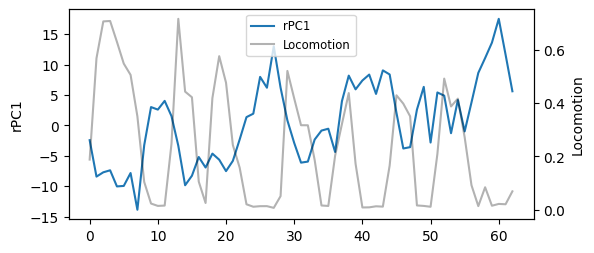

In [37]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(X_reduced[111:, 0])
plt.ylabel('rPC1')
plt.twinx()
plt.plot(0,0,label='rPC1')
plt.plot(y[111:], color='k',alpha=0.3, label='Locomotion')
plt.ylabel('Locomotion')
plt.legend(loc=9,fontsize='small')
plt.savefig('PCA_vs_Locomotion_animal3.pdf', dpi=300)

In [24]:
# loading analyses of PC1 -- which compounds have strong loadings?
loadings = rpca.components_.T  # shape (n_features, n_components)
pc1_loadings = loadings[:, 0]  # first principal component loadings
# sort by absolute value of loadings
sorted_indices = np.argsort(np.abs(pc1_loadings))[::-1]
sorted_loadings = pc1_loadings[sorted_indices]
sorted_compounds = np.array(common_comps)[sorted_indices]

In [25]:
sorted_compounds, sorted_loadings

(array(['Threonine', 'Proline', 'Alanine', 'Lysyl-Glutamic acid',
        'Glutamyl-Methionine/Methionyl-Glutamic acid',
        'Methionyl-Glutamic acid', 'Serine', 'Asparagine',
        'Glutamyl-Alanine', 'Histidine',
        'Glutamic acid/L-4-Hydroxyglutamate semialdehyde',
        'Prolyl-Proline', 'Aminoadipic acid', '3-Hydroxy-L-proline',
        'Aminoacrylic acid', 'Isomer 2 of 5-Aminopentanoic acid',
        'Glutamyl-Phenylalanine', 'L-Cysteinylglycine disulfide',
        'Phenylalanine', '5-Aminopentanal', 'Pantothenic acid',
        'Isomer 1 of 5-Aminopentanoic acid',
        'Cysteineglutathione disulfide', 'Allysine', 'Prolyl-Alanine',
        'Arginine', 'Glycyl-Proline', 'Cystine', '4-Ethylphenol',
        'Citrulline', 'cis-4-Hydroxy-D-proline', 'Tyrosyl-Glutamic acid',
        'Aspartic acid', 'Prolyl-Glycine', 'Ectoine', 'N-Methyl-Glycine',
        'Glutamyl-Glycine', 'Glutamyl-Isoleucine',
        'Glutaminyl-Glutamic acid', '4-Oxoproline', 'N(6)-Methyllysine',
 

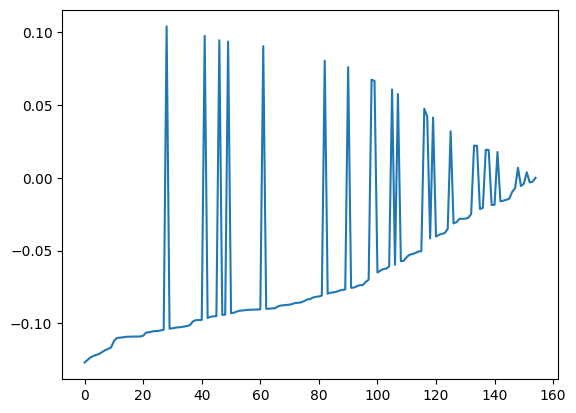

In [27]:
plt.plot(sorted_loadings)

In [1]:
# same for second, third and 4th PC
plt.figure(figsize=(9, 5))
for p in range(6):
    plt.subplot(2,3,p+1)
    # plt.xcorr(X_reduced[:, p], y, maxlags=maxlag)
    plt.stem(*spearman_ccf(X_reduced[:, p], y, max_lag=maxlag))
    plt.xticks(np.arange(-maxlag, maxlag + 1, 2), labels=(np.arange(-maxlag, maxlag + 1, 2)*7.5).astype(int))   
    plt.xlabel('PCA Lag (minutes)')
    plt.ylabel('X-corr. (Spearman r)')
    plt.title(f'xcorr  rPC{p+1} vs. Loco')
    plt.axvline(0, color='k', linestyle='--',alpha=0.3)
plt.tight_layout()
# plt.savefig('PCA_vs_Locomotion_multiple_PCs.pdf', dpi=300)
plt.show()

NameError: name 'plt' is not defined